In [1]:
from qiskit.circuit import QuantumCircuit, Parameter
from qiskit.circuit.library import RYGate, CRYGate
from qiskit.visualization import circuit_drawer

from susy_qm import calculate_Hamiltonian2

import pennylane as qml
import numpy as np

from qiskit import QuantumCircuit
from qiskit.quantum_info import SparsePauliOp
from qiskit.transpiler import generate_preset_pass_manager
from qiskit_ibm_runtime import EstimatorV2 as Estimator
from qiskit_ibm_runtime import EstimatorOptions
from qiskit_aer import AerSimulator
from qiskit.quantum_info import Statevector

In [9]:
potential = 'QHO'
cutoff = 8
shots = None

H = calculate_Hamiltonian2(cutoff, potential)
eigenvalues = np.sort(np.linalg.eig(H)[0])[:4]
min_eigenvalue = min(eigenvalues.real)

num_qubits = int(1 + np.log2(cutoff))

observables = SparsePauliOp.from_operator(H)
backend = AerSimulator(method="statevector")

params = np.random.rand(2)

In [10]:
qml.pauli_decompose(H)

(
    3.5 * (I(0) @ I(1) @ I(2) @ I(3))
  + 0.5 * (I(0) @ I(1) @ I(2) @ Z(3))
  + -0.49999999999999994 * (I(0) @ Z(1) @ I(2) @ I(3))
  + -0.49999999999999994 * (I(0) @ Z(1) @ Z(2) @ I(3))
  + -1.4999999999999998 * (Z(0) @ I(1) @ I(2) @ I(3))
  + -0.5 * (Z(0) @ I(1) @ Z(2) @ I(3))
  + -0.4999999999999999 * (Z(0) @ Z(1) @ I(2) @ I(3))
  + 0.49999999999999967 * (Z(0) @ Z(1) @ Z(2) @ I(3))
)

In [11]:
observables

SparsePauliOp(['IIII', 'IIIZ', 'IZII', 'IZZI', 'ZIII', 'ZIZI', 'ZZII', 'ZZZI'],
              coeffs=[ 3.5+0.j,  0.5+0.j, -0.5+0.j, -0.5+0.j, -1.5+0.j, -0.5+0.j, -0.5+0.j,
  0.5+0.j])

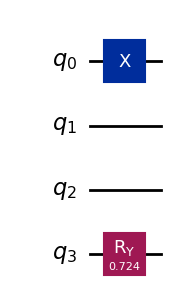

In [12]:
qc = QuantumCircuit(num_qubits)   
n=num_qubits-1

##QHO
#'''
qc.x(0)    
qc.ry(params[0], n)
#'''
##AHO
#qc.x(0)    
#qc.ry(params[0], 3)
#qc.ry(params[1], 2)

##DW
'''
qc.ry(params[0], 3)   
qc.ry(params[1], 1)
qc.append(CRYGate(params[2]), [1, 2])
qc.ry(params[3], 2)
qc.ry(params[4], 1)
'''

qc.draw('mpl')

In [13]:
state = Statevector.from_instruction(qc)
expectation = state.expectation_value(observables)
expectation

np.complex128(0.5012854801068976+0j)

In [356]:
options = EstimatorOptions()
options.default_shots = 10000000
options.optimization_level = 0
backend = AerSimulator()
estimator = Estimator(backend, options=options)

pm = generate_preset_pass_manager(backend=backend, optimization_level=3)
isa_circuit = pm.run(qc)
mapped_observables = [
    observable.apply_layout(isa_circuit.layout) for observable in observables
]

job = estimator.run([(qc, observables)])
#job = estimator.run([(isa_circuit, mapped_observables)])
energy = job.result()[0].data.evs.sum()

c:\Users\Johnk\Documents\PhD\Quantum Computing Code\Quantum-Computing\.venv\Lib\site-packages\qiskit_ibm_runtime\fake_provider\local_service.py:232: UserWarning: Options {'transpilation': {'optimization_level': 0}} have no effect in local testing mode.
  warnings.warn(f"Options {options_copy} have no effect in local testing mode.")


(<Figure size 500x500 with 1 Axes>, <Axes: >)

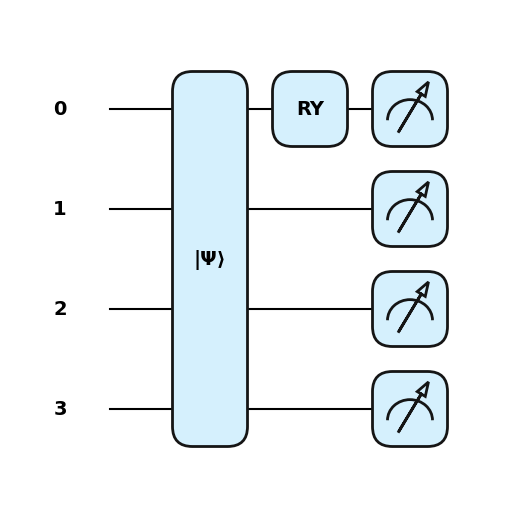

In [14]:
dev = qml.device('default.qubit', wires=num_qubits,shots=None)
n=num_qubits-1
@qml.qnode(dev)
def cost_function(params):

    #basis_state = [0]*(num_qubits-1) + [1]
    #qml.BasisState(basis_state, wires=range(num_qubits))
    #qml.RY(params[0], wires=[0])
    #qml.RY(params[1], wires=[1])

    #'''
    basis_state = [0]*(num_qubits-1) + [1]
    qml.BasisState(basis_state, wires=range(num_qubits))
    qml.RY(params[0], wires=[0])
    #'''
   
    '''
    basis_state = [0]*num_qubits
    qml.BasisState(basis_state, wires=range(num_qubits))
    
    qml.RY(params[0], wires=[n-3])
    qml.RY(params[1], wires=[n-1])
    qml.CRY(params[2], wires=[n-1, n-2])
    qml.RY(params[3], wires=[n-2])
    qml.RY(params[4], wires=[n-1])
    '''

    return qml.expval(qml.Hermitian(H, wires=range(num_qubits)))

qml.draw_mpl(cost_function, style='pennylane')(params)
    

In [15]:
cost_function(params)

np.float64(0.5012854801068973)

In [ ]:
num_qubits = 6
dev = qml.device("default.qubit", wires=num_qubits)
n=num_qubits-1
@qml.qnode(dev)
def circuit(params):

    basis_state = [0]*num_qubits
    qml.BasisState(basis_state, wires=range(num_qubits))
    
    qml.RY(params[0], wires=[n-3])
    qml.RY(params[1], wires=[n-1])
    qml.CRY(params[2], wires=[n-1, n-2])
    qml.RY(params[3], wires=[n-2])
    qml.RY(params[4], wires=[n-1])

params = np.random.rand(5)
qml.draw_mpl(circuit, style='pennylane')(params)

(<Figure size 700x700 with 1 Axes>, <Axes: >)

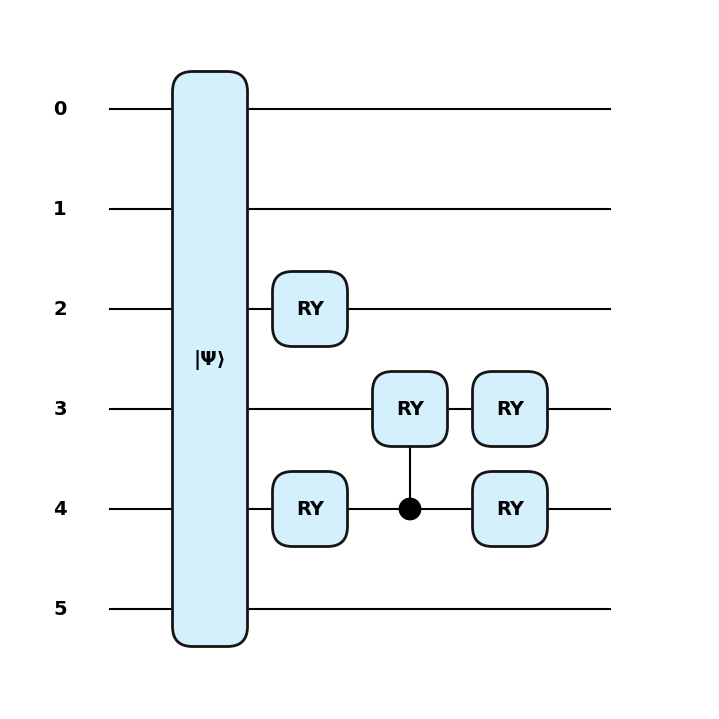

In [45]:
params = np.random.rand(5)
qml.draw_mpl(circuit, style='pennylane')(params)

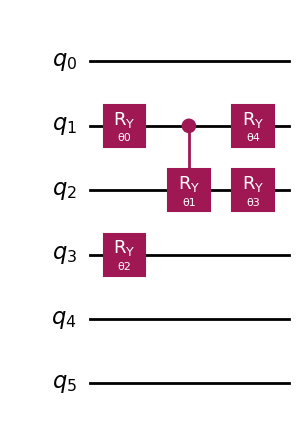

In [43]:
param_objs = [Parameter(f"θ{i}") for i in range(5)]

num_qubits = 6
qc = QuantumCircuit(num_qubits)
n=num_qubits-1
           
qc.ry(param_objs[0], 1)
qc.append(CRYGate(param_objs[1]), [1, 2])
qc.ry(param_objs[2], 3)
qc.ry(param_objs[3], 2)
qc.ry(param_objs[4], 1)

qc.draw('mpl')


(<Figure size 500x700 with 1 Axes>, <Axes: >)

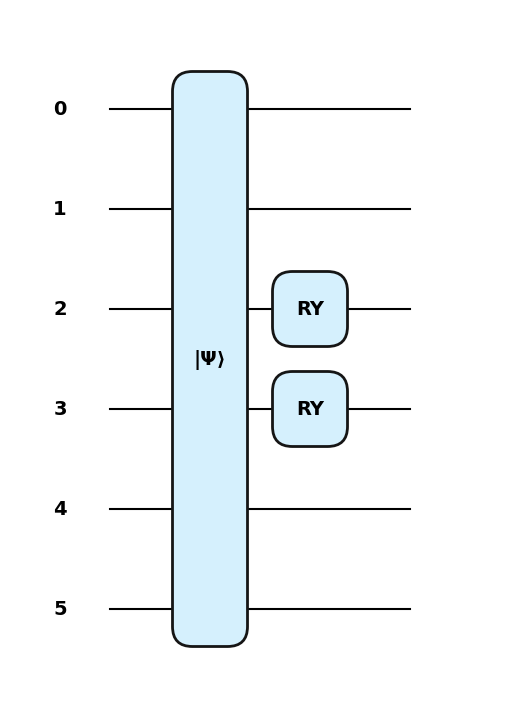

In [49]:
num_qubits = 6
dev = qml.device("default.qubit", wires=num_qubits)
n=num_qubits-1
@qml.qnode(dev)
def circuit(params):

    basis_state = [0]*(num_qubits-1) + [1]
    qml.BasisState(basis_state, wires=range(num_qubits))
    
    qml.RY(params[0], wires=[n-2])
    qml.RY(params[1], wires=[n-3])

params = np.random.rand(2)
qml.draw_mpl(circuit, style='pennylane')(params)

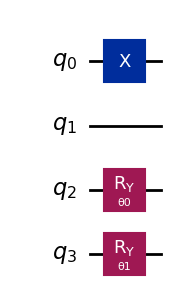

In [52]:
param_objs = [Parameter(f"θ{i}") for i in range(2)]

num_qubits = 4
qc = QuantumCircuit(num_qubits)
n=num_qubits-1

qc.x(0)             
qc.ry(param_objs[0], n - (n-2)) 
qc.ry(param_objs[1], n - (n-3))

qc.draw('mpl')


In [12]:
from susy_qm import calculate_Hamiltonian2

import pennylane as qml
from pennylane import numpy as np
from pennylane_qiskit.converter import circuit_to_qiskit

In [33]:
potential = "AHO"
cutoff = 8
H = calculate_Hamiltonian2(cutoff, potential)

num_qubits = int(1 + np.log2(cutoff))

(<Figure size 600x400 with 1 Axes>, <Axes: >)

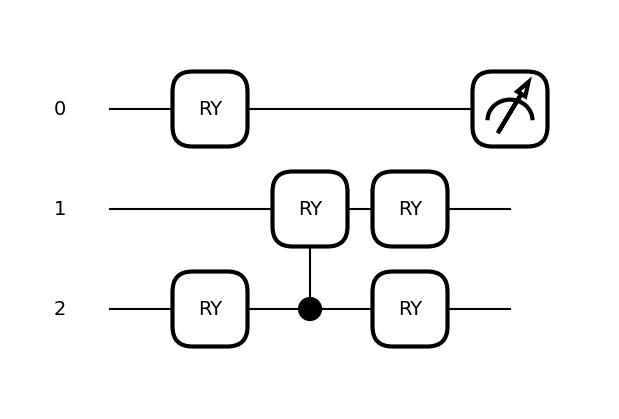

In [37]:
dev = qml.device("qiskit.aer", wires=num_qubits)
@qml.qnode(dev)
def circuit(params):

    basis = [0]*(num_qubits - 1) + [0]
    for i, b in enumerate(basis):
        if b == 1:
            qml.PauliX(i)
            
    #qml.RY(params[0], wires=num_qubits - 4)
    #qml.RY(params[1], wires=num_qubits - 3)

    qml.RY(params[0], wires=[num_qubits-2])
    qml.CRY(params[1], wires=[num_qubits-2, num_qubits-3])
    qml.RY(params[2], wires=[num_qubits-4])
    qml.RY(params[3], wires=[num_qubits-3])
    qml.RY(params[4], wires=[num_qubits-2])

    return qml.expval(qml.PauliZ(0))

params = np.random.randn(5)
qml.draw_mpl(circuit)(params)

In [39]:



_ = circuit(params)

tape = circuit.qtape
dev.reset()
dev.apply(tape.operations)

raw_dev = dev._device
qiskit_circuit = raw_dev._circuit
qiskit_circuit.draw()


┌──────────────┐                ┌─┐                     
q_0: ┤ Ry(-0.78836) ├────────────────┤M├─────────────────────
     └──────────────┘┌──────────────┐└╥┘┌─────────────┐┌─┐   
q_1: ────────────────┤ Ry(-0.27421) ├─╫─┤ Ry(0.21736) ├┤M├───
     ┌─────────────┐ └──────┬───────┘ ║ ├─────────────┤└╥┘┌─┐
q_2: ┤ Ry(-1.2954) ├────────■─────────╫─┤ Ry(-1.2759) ├─╫─┤M├
     └─────┬─┬─────┘                  ║ └─────────────┘ ║ └╥┘
q_3: ──────┤M├────────────────────────╫─────────────────╫──╫─
           └╥┘                        ║                 ║  ║ 
c: 4/═══════╩═════════════════════════╩═════════════════╩══╩═
            3                         0                 1  2